In [18]:
import tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import seaborn as sns

In [7]:
def fetch_cos_value(seq_len, freq=0.01, noise=0.1):
    np.random.seed(101)
    x = np.arange(0.0, seq_len, 1.0)
    return np.cos(2 * np.pi * freq * x) + np.random.uniform(low=noise, high=noise, size=seq_len)

In [8]:
print(fetch_cos_value(10, freq=0.1))

[ 1.1         0.90901699  0.40901699 -0.20901699 -0.70901699 -0.9
 -0.70901699 -0.20901699  0.40901699  0.90901699]


In [10]:
# 데이터 불러오기

import FinanceDataReader as fdr
df_samsung = fdr.DataReader('005930')
df_samsung

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-05-02,1340,1359,1284,1285,236600,NaN
1998-05-04,1266,1275,1230,1240,274250,-0.035019
1998-05-06,1219,1239,1204,1210,312220,-0.024194
1998-05-07,1213,1245,1210,1233,316361,0.019008
1998-05-08,1213,1232,1200,1210,333190,-0.018654
...,...,...,...,...,...,...
2022-06-30,57200,57600,57000,57000,18915142,-0.017241
2022-07-01,56900,57500,55900,56200,24982097,-0.014035
2022-07-04,56100,57400,55700,57100,17807126,0.016014


In [13]:
def date_obj_to_str(date_obj):
    return date_obj.strftime('%Y-%m-%d')

def save_pickle(something, path):
    if not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))

    with open(path, 'wb') as fh:
        pickle.dump(something, fh, pickle.DEFAULT_PROTOCOL)

def load_pickle(path):
    with open(path, 'rb') as fh:
        return pickle.load(fh)

def call_stock_price(symbol, from_date, to_date, cache_path="./tmp/prices/"):
    assert(from_date <= to_date)
    filename = "{}_{}_{}.pk".format(symbol, str(from_date), str(to_date))
    price_filepath = os.path.join(cache_path, filename)

    try:
        prices = load_pickle(price_filepath)
        print('loaded from', price_filepath)
    except IOError:
        historic = fdr.DataReader(symbol, start=date_obj_to_str(from_date), end=date_obj_to_str(to_date))
        prices = historic['Close'].tolist()
        save_pickle(prices, price_filepath)
        print('save into', price_filepath)

    return prices

In [15]:
import datetime

print(call_stock_price('GOOG', datetime.date(2020, 6, 1), datetime.date(2020, 6, 30)))

save into ./tmp/prices/GOOG_2020-06-01_2020-06-30.pk
[1431.82, 1439.22, 1436.38, 1412.18, 1438.39, 1446.61, 1456.16, 1465.85, 1403.84, 1413.18, 1419.85, 1442.72, 1451.12, 1435.96, 1431.72, 1451.86, 1464.41, 1431.97, 1441.33, 1359.9, 1394.97, 1413.61]


In [16]:
def format_dataset(values, temporal_features):
    feat_splits = [values[i: i+temporal_features] for i in range(len(values) - temporal_features)]
    features = np.vstack(feat_splits)
    labels = np.array(values[temporal_features:])

    return features, labels

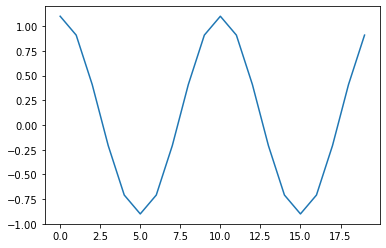

In [23]:
np.set_printoptions(precision=2)

cos_values = fetch_cos_value(20, freq=0.1)
plt.plot(cos_values)

In [27]:
feature_size = 5
minibatch_cos_x, minibatch_cos_y = format_dataset(cos_values, feature_size)
print('minibatch_cos_x shape=\n', minibatch_cos_x.shape,'\n')
print('minibatch_cos_y shape=\n',minibatch_cos_y.shape)

minibatch_cos_x shape=
 (15, 5) 

minibatch_cos_y shape=
 (15,)


In [26]:
minibatch_cos_x[0]

array([ 1.1 ,  0.91,  0.41, -0.21, -0.71])

Observation 0: x=[ 1.1   0.91  0.41 -0.21 -0.71], y=-0.9
Observation 1: x=[ 0.91  0.41 -0.21 -0.71 -0.9 ], y=-0.7090169943749475
Observation 2: x=[ 0.41 -0.21 -0.71 -0.9  -0.71], y=-0.20901699437494756
Observation 3: x=[-0.21 -0.71 -0.9  -0.71 -0.21], y=0.4090169943749472
Observation 4: x=[-0.71 -0.9  -0.71 -0.21  0.41], y=0.9090169943749473


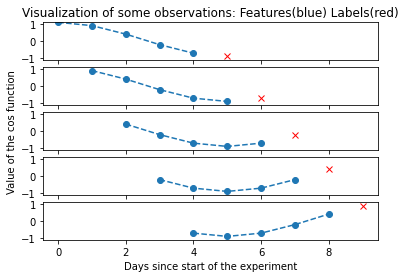

In [28]:
samples_to_plot = 5
f, axarr = plt.subplots(samples_to_plot, sharex=True)

for i in range(samples_to_plot):
    features = minibatch_cos_x[i, :]
    label = minibatch_cos_y[i]
    print(f'Observation {i}: x={features}, y={label}')
    plt.subplot(samples_to_plot, 1, i+1)
    axarr[i].plot(range(i, feature_size+i), features, '--o')
    axarr[i].plot([feature_size+i], label, 'rx')
    axarr[i].set_ylim([-1.1, 1.1])

plt.xlabel('Days since start of the experiment')
axarr[2].set_ylabel('Value of the cos function')
axarr[0].set_title('Visualization of some observations: Features(blue) Labels(red)')
plt.show()

loaded from ./tmp/prices/005930_2008-01-01_2022-06-30.pk
loaded from ./tmp/prices/000660_2008-01-01_2022-06-30.pk
loaded from ./tmp/prices/035420_2008-01-01_2022-06-30.pk
loaded from ./tmp/prices/035720_2008-01-01_2022-06-30.pk
loaded from ./tmp/prices/105560_2008-01-01_2022-06-30.pk


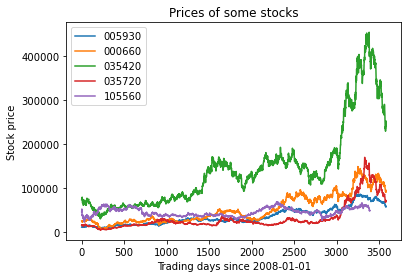

In [40]:
symbols = {'005930':'삼성전자',
           '000660':'SK하이닉스',
           '035420':'NAVER',
           '035720':'카카오',
           '105560':'KB금융'}
symbol_list = list(symbols.keys())
symbol_name = list(symbols.values())

start_date = datetime.date(2008,1,1)
end_date = datetime.date(2022,6,30)

ax = plt.subplot(1,1,1)
for sym in symbol_list:
    prices = call_stock_price(sym, start_date, end_date)
    ax.plot(range(len(prices)), prices, label=sym)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.xlabel(f'Trading days since {date_obj_to_str(start_date)}')
plt.ylabel('Stock price')
plt.title('Prices of some stocks')
plt.show()

In [41]:
def matrix_to_array(m):
    return np.asarray(m).reshape(-1)

In [42]:
def evaluate_ts(features, y_true, y_pred):
    print('Evaluation of predictions:')
    print('MSE:', np.mean(np.square(y_true-y_pred)))
    print('MAE:', np.mean(np.abs(y_true - y_pred)))

    print('Benchmark: if prediction == last feature')
    print('MSE:', np.mean(np.square(features[:, -1] - y_true)))
    print('MAE', np.mean(np.abs[features[:, -1] - y_true]))

    plt.plot(matrix_to_array(y_true), 'b')
    plt.plot(matrix_to_array(y_pred), 'r--')
    plt.xlabel('Days')
    plt.ylabel('Predicted, True values')
    plt.title('Real(blue) VS Predicted(red)')
    plt.show()

    error = np.abs(matrix_to_array(y_pred) - matrix_to_array(y_true))
    plt.plot(error, 'r')
    fit = np.polyfit(range(len(error)), error, deg=1)
    plt.plot(fit[0] * range(len(error)) + fit[1], '--')
    plt.xlabel('Days')
    plt.ylabel('Prediction error L1 norm')
    plt.title('Prediction error')
    plt.show()

In [43]:
# tensorflow version == 2
# tf.compat.v1: version 1과 호환되게 해줌

import tensorflow as tf
from tensorflow_addons import rnn

# 기존 그래프를 삭제하고 reset 시켜 중복되는 것을 방지
# tf.compat.v1.reset_default_graph()
tf.compat.v1.set_random_seed(101)

In [44]:
feat_dimension = 20
train_size = 250
test_size = 250
lr = 0.01
optimizer = tf.compat.v1.train.AdamOptimizer
n_epocs = 10

In [46]:
cos_values = fetch_cos_value(train_size + test_size + feat_dimension)
minibatch_cos_x, minibatch_cos_y = format_dataset(cos_values, feat_dimension)
train_x = minibatch_cos_x[:train_size, :].astype(np.float32)
train_y = minibatch_cos_y[:train_size].reshape((-1, 1)).astype(np.float32)
test_x = minibatch_cos_x[train_size:, :].astype(np.float32)
test_y = minibatch_cos_y[train_size:].reshape((-1, 1)).astype(np.float32)

tf.compat.v1.disable_eager_execution()
X_tf = tf.compat.v1.placeholder('float', shape=(None, feat_dimension), name='X')
y_tf = tf.compat.v1.placeholder('float', shape=(None, 1), name='y')

In [47]:
def regression_ANN(x, weights, biases):
    return tf.add(biases, tf.matmul(x, weights))

In [52]:
weights = tf.Variable(tf.compat.v1.truncated_normal([feat_dimension, 1], mean=0.0, stddev=1.0), name='weights')
biases = tf.Variable(tf.zeros([1,1]), name='biases')

y_pred = regression_ANN(X_tf, weights, biases)
cost = tf.reduce_mean(tf.square(y_tf - y_pred))
train_op = optimizer(lr).minimize(cost)

In [53]:
train_op

<tf.Operation 'Adam_1' type=NoOp>

In [ ]:
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())

    for i in range(n_epocs):
        train_cost, _ = sess.run([cost, train_op], feed_dict={X_tf: train_x, y_tf})